In [1]:
import  jpholiday
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from prophet import Prophet
import joblib
from sklearn.model_selection import train_test_split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# 気象データの収集及び作成
class Weather_Data:
    def __init__(self, years):
        self.years = years

    def temprature(self):
        df_t = pd.DataFrame()
        for year in years:
            d_t = pd.read_csv(f'{year}_temp.csv', encoding='shift-jis', skiprows=1)
            df_t = pd.concat([df_t, d_t], axis=0)

        # 気温情報の整理
        df_t = df_t[~(df_t['Unnamed: 0']=='年月日時') & ~(df_t['東京.1']=='品質情報')]
        df_t = df_t.drop(columns=['東京.1', '東京.2'])
        df_t.columns=['年月日時', '気温(℃)']
        df_t = df_t.reset_index(drop=True)
        return df_t

    def sun(self):
        df_s = pd.DataFrame()
        for year in years:
            d_s = pd.read_csv(f'{year}_sun.csv', encoding='cp932', skiprows=1)
            df_s = pd.concat([df_s, d_s], axis=0)

        # 日照量の整理
        df_s = df_s[~(df_s['Unnamed: 0']=='年月日時') & ~(df_s['東京.1']=='品質情報')]
        df_s = df_s.drop(columns=['東京.1', '東京.2'])
        df_s.columns=['年月日時', '日射量(MJ/㎡)']
        df_s = df_s.reset_index(drop=True)
        return df_s

    def weather(self):
        df_w = pd.DataFrame()
        for year in years:
            d_w = pd.read_csv(f'{year}_wet.csv', encoding='shift-jis', skiprows=1)
            df_w = pd.concat([df_w, d_w], axis=0)

        # 日照時間の整理
        df_w = df_w[~(df_w['Unnamed: 0']=='年月日時') & ~(df_w['東京.1']=='品質情報')] # 年月日　と　品質情報 を含む行いが意を抽出
        df_w = df_w.drop(columns=['東京.1', '東京.2']) # 左記の２つを列から削除
        df_w.columns=['年月日時', '天気'] # カラム名を左記の２つに変更
        df_w = df_w.reset_index(drop=True)
        df_w = df_w.fillna(0)
        return df_w
    
    
years = ['R1', 'R2', 'R3', 'R4']
    
weather_data = Weather_Data(years)
df_temp = weather_data.temprature()
df_sun = weather_data.sun()
df_weather = weather_data.weather()

In [4]:
# 気温、日照時間、天気の表を年月日時の項目を基準として merge
def merge():
    df = pd.merge(df_temp, df_sun, on='年月日時') # 天気と気温の merge
    df = pd.merge(df, df_weather, on='年月日時') # 上で merge した df と天気を merge
    df['年月日時'] = pd.to_datetime(df['年月日時'], format='%Y-%m-%d %H:%M')


    # indexを　年月日時 に変更
    df = df.reset_index(drop=True)
    df = df.reindex(columns=['年月日時', '気温(℃)', '天気', '日射量(MJ/㎡)'])
    return df

df = merge()
df

,年月日時,気温(℃),天気,日射量(MJ/㎡)
0,2019-04-01 01:00:00,8.2,0,0
1,2019-04-01 02:00:00,7.8,0,0
2,2019-04-01 03:00:00,7.3,1,0
3,2019-04-01 04:00:00,7.1,0,0
4,2019-04-01 05:00:00,6.7,0,0.00
...,...,...,...,...
35059,2023-03-31 20:00:00,15.1,0,0
35060,2023-03-31 21:00:00,14.3,1,0
35061,2023-03-31 22:00:00,13.6,0,0
35062,2023-03-31 23:00:00,13.1,0,0


In [5]:
# 電力需要実績
class electric:
    def __init__(self, years):
        self.years = years
        
        
    def demand_data(self):
        df_e = pd.DataFrame()
        for year in years:
            _df = pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv', encoding='shift-jis', skiprows=1)
            df_e = pd.concat([df_e, _df], axis=0)
            df_e = df_e.reset_index(drop=True)
            df_e

        # 日時データを気象要素と統一する
        datetimes = []

        for i, val in df_e.iterrows():
            date = val['DATE']
            time = val['TIME']
            str_datetime = f'{date} {time}'
            datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
            datetimes.append(datetime)
        df_e['年月日時'] = datetimes
        df_e['年月日時'] = pd.to_datetime(df_e['年月日時'], format='%Y-%m-%d %H:%M')


        # DATE と　TIME 列を drop　し日時情報を　年月日時　のみにする
        df_e.drop(columns=['DATE', 'TIME'], inplace=True)


        # 気象データにない日時データを削除し、年月日時をindexに変更する

        df_e = df_e.loc[~((df_e['年月日時'] >= '2019-01-01 00:00:00') & (df_e['年月日時'] <='2019-04-01 00:00:00'))]
        df_e = df_e.loc[~(df_e['年月日時'] >= '2023-04-01 01:00:00')]
        df_e = df_e.reset_index(drop=True)
        df_e = df_e.reindex(columns=['年月日時', '実績(万kW)'])
        return df_e

    
years = [2019, 2020, 2021, 2022, 2023]

power_demand = electric(years)
df_e = power_demand.demand_data()
df_e

,年月日時,実績(万kW)
0,2019-04-01 01:00:00,2493
1,2019-04-01 02:00:00,2480
2,2019-04-01 03:00:00,2493
3,2019-04-01 04:00:00,2547
4,2019-04-01 05:00:00,2712
...,...,...
35059,2023-03-31 20:00:00,2898
35060,2023-03-31 21:00:00,2759
35061,2023-03-31 22:00:00,2639
35062,2023-03-31 23:00:00,2510


In [6]:
# 気象データと電力需要データを「年月日時」を基準に結合する
def merge_weather_electric(df, df_e):
    df = pd.merge(df, df_e, on='年月日時') 
    df = df.reindex(columns=['年月日時', '実績(万kW)', '気温(℃)', '天気', '日射量(MJ/㎡)'])
    return df

df = merge_weather_electric(df, df_e)

In [7]:
def add_holiday(df):
    df['休・祝日'] = df['年月日時'].apply(lambda x: 1 if jpholiday.is_holiday(x) or x.weekday() >= 5 else 0)
    return df

df = add_holiday(df)

In [8]:
# 統計量を出せるようにデータ型を変更する
def change_type(df):
    df['気温(℃)'] = pd.to_numeric(df['気温(℃)'], errors='coerce')
    df['天気'] = pd.to_numeric(df['天気'], errors='coerce')
    df['日射量(MJ/㎡)'] = pd.to_numeric(df['日射量(MJ/㎡)'] , errors='coerce')
    return df
df = change_type(df)

In [9]:
# Nan データの削除
def del_nan_data(df):
    df = df.dropna(subset=['気温(℃)', '日射量(MJ/㎡)'])
    return df

df = del_nan_data(df)

### prophetで使用できるようにdfを加工する

In [10]:
df_p = df

# prophetに必要な「ds」、「y」　カラムの作成
def create_columns(df):
    df = df.rename(columns={'年月日時': 'ds', '実績(万kW)': 'y'})
    df['DATE'] = df['ds']
    df['DATE'] = df['DATE'].astype(str)
    return df
df_p = create_columns(df)
df_p = df_p

In [11]:
# 年月日、時間　カラムを作成
def create_date_time(df_p):
    TIME = []
    DATE = []
    for index, data in df_p.iterrows():
        date = data['DATE'][:10]
        time = data['DATE'][11:16]
        DATE.append(date)
        TIME.append(time)

    df_p['DATE'] = DATE
    df_p['TIME'] = TIME
    df_p = df_p.reindex(columns=['ds', 'DATE', 'TIME', 'y', '天気', '気温(℃)', '日射量(MJ/㎡)', '休・祝日'])
    return df_p
df_p = create_date_time(df_p)
df_p = df_p

In [12]:
holidays = pd.DataFrame({
    'ds':df_p['ds'],
    'holiday':df_p['休・祝日'].astype(str),
    
})

# 30℃以上モデル作成

In [28]:
# ３０℃以上のモデル用データの作成

df_pr = pd.DataFrame({
    'ds':df_p['ds'],
    'temp':df_p['気温(℃)']
})

def categorize_temp(temp):
    if temp >= 34.0:
        return 1
    elif 33.0 <= temp < 34.0:
        return 0.8
    elif 32.0 <= temp < 33.0:
        return 0.6
    elif 31.0 <= temp < 32.0:
        return 0.4
    elif 30.0 <= temp < 31:
        return 0.2
    else:
        return 0
df_pr['temp'] = df_pr['temp'].apply(categorize_temp)
df_p['temp'] = df_pr['temp']
df_p

,ds,DATE,TIME,y,天気,気温(℃),日射量(MJ/㎡),休・祝日,temp
0,2019-04-01 01:00:00,2019-04-01,01:00,2493,0,8.2,0.0,0,0.0
1,2019-04-01 02:00:00,2019-04-01,02:00,2480,0,7.8,0.0,0,0.0
2,2019-04-01 03:00:00,2019-04-01,03:00,2493,1,7.3,0.0,0,0.0
3,2019-04-01 04:00:00,2019-04-01,04:00,2547,0,7.1,0.0,0,0.0
4,2019-04-01 05:00:00,2019-04-01,05:00,2712,0,6.7,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
35059,2023-03-31 20:00:00,2023-03-31,20:00,2898,0,15.1,0.0,0,0.0
35060,2023-03-31 21:00:00,2023-03-31,21:00,2759,1,14.3,0.0,0,0.0
35061,2023-03-31 22:00:00,2023-03-31,22:00,2639,0,13.6,0.0,0,0.0
35062,2023-03-31 23:00:00,2023-03-31,23:00,2510,0,13.1,0.0,0,0.0


In [29]:
# ３０℃以上モデルの作成
model_hot = Prophet(
    holidays=holidays)
model_hot.add_regressor('temp').fit(df_p)
# model_hot.fit(df_p)

21:31:13 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
future = pd.DataFrame({
    'ds':df_p['ds'],
    'temp':df_p['temp']
})
future
# future = model_hot.make_future_dataframe(periods=24*365, freq='H')
pred_hot = model_hot.predict(future)

In [31]:
pred_hot.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,0,0_lower,0_upper,1,1_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,...,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.0,35058.0,35058.0,35058.000000
mean,2864.857254,2872.810075,3551.684522,2864.857254,2864.857254,289.867380,289.867380,289.867380,57.548271,57.548271,...,0.139278,0.139278,0.139278,-0.003719,-0.003719,-0.003719,0.0,0.0,0.0,3212.349768
std,81.610355,615.194068,615.210762,81.610355,81.610355,202.488771,202.488771,202.488771,82.384036,82.384036,...,86.925160,86.925160,86.925160,338.033776,338.033776,338.033776,0.0,0.0,0.0,615.063735
min,2675.517442,1211.362468,1890.610255,2675.517442,2675.517442,0.000000,0.000000,0.000000,0.000000,0.000000,...,-200.425645,-200.425645,-200.425645,-621.371970,-621.371970,-621.371970,0.0,0.0,0.0,1555.730138
25%,2814.476047,2452.315353,3129.985487,2814.476047,2814.476047,0.000000,0.000000,0.000000,0.000000,0.000000,...,-37.035679,-37.035679,-37.035679,-289.813480,-289.813480,-289.813480,0.0,0.0,0.0,2791.284450
50%,2867.153586,2884.672725,3564.500740,2867.153586,2867.153586,431.313213,431.313213,431.313213,0.000000,0.000000,...,44.953496,44.953496,44.953496,-27.301154,-27.301154,-27.301154,0.0,0.0,0.0,3225.108251
75%,2915.980036,3257.498348,3934.971280,2915.980036,2915.980036,431.313213,431.313213,431.313213,175.482932,175.482932,...,52.821507,52.821507,52.821507,276.681583,276.681583,276.681583,0.0,0.0,0.0,3596.466679
max,3091.190400,5367.768403,6052.503480,3091.190400,3091.190400,431.313213,431.313213,431.313213,175.482932,175.482932,...,85.077956,85.077956,85.077956,699.219699,699.219699,699.219699,0.0,0.0,0.0,5707.634452


In [32]:
pred_hot.loc[(pred_hot['yhat'].idxmax())]

ds                                 2022-08-02 10:00:00
trend                                      2888.794178
yhat_lower                                 5318.405532
yhat_upper                                  6052.50348
trend_lower                                2888.794178
trend_upper                                2888.794178
0                                           431.313213
0_lower                                     431.313213
0_upper                                     431.313213
1                                                  0.0
1_lower                                            0.0
1_upper                                            0.0
additive_terms                             2818.840274
additive_terms_lower                       2818.840274
additive_terms_upper                       2818.840274
daily                                       419.339601
daily_lower                                 419.339601
daily_upper                                 419.339601
extra_regr

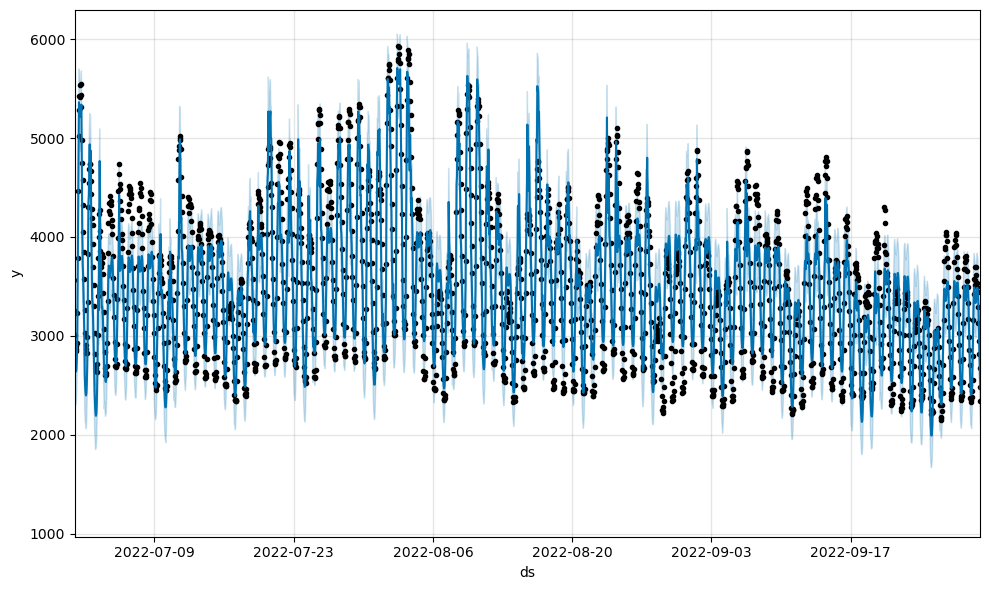

In [33]:
model_hot.plot(pred_hot)
plt.xlim(dt(2022, 7, 1), dt(2022, 9, 30))
plt.show()

In [34]:
df_2022 = pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-2022.csv', encoding='shift-jis', skiprows=1)
datetimes = []
for i, val in df_2022.iterrows():
    date = val['DATE']
    time = val['TIME']
    str_datetime = f'{date} {time}'
    datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
    datetimes.append(datetime)
df_2022['ds'] = pd.Series(datetimes[:len(df_2022)])
df_2022['ds'] = datetimes
df_2022['ds'] = pd.to_datetime(df_2022['ds'], format='%Y-%m-%d %H:%M')

df_2022 = df_2022[(df_2022['ds'] >= dt(2022, 7, 1)) & (df_2022['ds'] < dt(2022, 9, 30))].reset_index(drop=True)

df_2022

,DATE,TIME,実績(万kW),ds
0,2022/7/1,0:00,3247,2022-07-01 00:00:00
1,2022/7/1,1:00,3012,2022-07-01 01:00:00
2,2022/7/1,2:00,2897,2022-07-01 02:00:00
3,2022/7/1,3:00,2864,2022-07-01 03:00:00
4,2022/7/1,4:00,2849,2022-07-01 04:00:00
...,...,...,...,...
2179,2022/9/29,19:00,3292,2022-09-29 19:00:00
2180,2022/9/29,20:00,3129,2022-09-29 20:00:00
2181,2022/9/29,21:00,2948,2022-09-29 21:00:00
2182,2022/9/29,22:00,2820,2022-09-29 22:00:00


In [35]:
pred_2022 = pred_hot[(pred_hot['ds'] >= dt(2022, 7, 1)) & (pred_hot['ds'] < dt(2022, 9, 30))].reset_index(drop=True)
# pred_2022 = pred_hot[(pred_hot['ds'] >= dt(2021, 1, 1)) & (pred_hot['ds'] < dt(2022, 1, 1))].reset_index(drop=True)

pred_2022

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,0,0_lower,0_upper,1,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-01 00:00:00,2915.982450,2481.955831,3171.837264,2915.982450,2915.982450,431.313213,431.313213,431.313213,0.0,...,34.861180,34.861180,34.861180,-38.903544,-38.903544,-38.903544,0.0,0.0,0.0,2830.571305
1,2022-07-01 01:00:00,2915.947504,2392.864036,3076.138546,2915.947504,2915.947504,431.313213,431.313213,431.313213,0.0,...,35.820572,35.820572,35.820572,-38.544783,-38.544783,-38.544783,0.0,0.0,0.0,2719.299469
2,2022-07-01 02:00:00,2915.912557,2330.343777,2986.511201,2915.912557,2915.912557,431.313213,431.313213,431.313213,0.0,...,37.000472,37.000472,37.000472,-38.185067,-38.185067,-38.185067,0.0,0.0,0.0,2659.028679
3,2022-07-01 03:00:00,2915.877611,2304.041417,3012.997792,2915.877611,2915.877611,431.313213,431.313213,431.313213,0.0,...,38.387830,38.387830,38.387830,-37.824388,-37.824388,-37.824388,0.0,0.0,0.0,2638.903731
4,2022-07-01 04:00:00,2915.842665,2339.131349,3031.199148,2915.842665,2915.842665,431.313213,431.313213,431.313213,0.0,...,39.965156,39.965156,39.965156,-37.462737,-37.462737,-37.462737,0.0,0.0,0.0,2665.963127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2022-09-29 19:00:00,2839.834320,3095.477953,3768.181434,2839.834320,2839.834320,431.313213,431.313213,431.313213,0.0,...,33.521411,33.521411,33.521411,-215.074803,-215.074803,-215.074803,0.0,0.0,0.0,3438.845278
2180,2022-09-29 20:00:00,2839.799373,2969.615587,3658.216796,2839.799373,2839.799373,431.313213,431.313213,431.313213,0.0,...,33.335321,33.335321,33.335321,-215.580009,-215.580009,-215.580009,0.0,0.0,0.0,3330.524877
2181,2022-09-29 21:00:00,2839.764427,2803.517670,3492.463301,2839.764427,2839.764427,431.313213,431.313213,431.313213,0.0,...,33.370114,33.370114,33.370114,-216.083760,-216.083760,-216.083760,0.0,0.0,0.0,3161.724003
2182,2022-09-29 22:00:00,2839.729481,2608.315121,3290.736145,2839.729481,2839.729481,431.313213,431.313213,431.313213,0.0,...,33.633900,33.633900,33.633900,-216.586057,-216.586057,-216.586057,0.0,0.0,0.0,2953.313428


In [36]:
df_2022 = df_2022.rename(columns={'実績(万kW)':'y'})

results = pd.DataFrame()

# 実測値
results['t'] = df_2022['y']

# 予測値
results['y'] = pred_2022['yhat']
results['diff'] = results['t'] - results['y']
results

,t,y,diff
0,3247,2830.571305,416.428695
1,3012,2719.299469,292.700531
2,2897,2659.028679,237.971321
3,2864,2638.903731,225.096269
4,2849,2665.963127,183.036873
...,...,...,...
2179,3292,3438.845278,-146.845278
2180,3129,3330.524877,-201.524877
2181,2948,3161.724003,-213.724003
2182,2820,2953.313428,-133.313428


In [37]:
np.mean(abs((results['y'] - results['t']) / results['t'])*100)

7.213326257417207

In [38]:
# 30℃以上特化モデルの保存
joblib.dump(model_hot, 'model_hot_elec.pkl')

['model_hot_elec.pkl']

# 通常モデル作成

In [22]:
# 通常モデル用データの作成
df_n = df_p

df_pr = pd.DataFrame({
    'ds':df_p['ds'],
    'temp':df_p['気温(℃)']
})
def categorize_temp(temp):
    if temp >= 30.0:
        return 1
    else:
        return 0

df_pr['temp'] = df_pr['temp'].apply(categorize_temp)
df_n['temp'] = df_pr['temp']
df_n

,ds,DATE,TIME,y,天気,気温(℃),日射量(MJ/㎡),休・祝日,temp
0,2019-04-01 01:00:00,2019-04-01,01:00,2493,0,8.2,0.0,0,0
1,2019-04-01 02:00:00,2019-04-01,02:00,2480,0,7.8,0.0,0,0
2,2019-04-01 03:00:00,2019-04-01,03:00,2493,1,7.3,0.0,0,0
3,2019-04-01 04:00:00,2019-04-01,04:00,2547,0,7.1,0.0,0,0
4,2019-04-01 05:00:00,2019-04-01,05:00,2712,0,6.7,0.0,0,0
...,...,...,...,...,...,...,...,...,...
35059,2023-03-31 20:00:00,2023-03-31,20:00,2898,0,15.1,0.0,0,0
35060,2023-03-31 21:00:00,2023-03-31,21:00,2759,1,14.3,0.0,0,0
35061,2023-03-31 22:00:00,2023-03-31,22:00,2639,0,13.6,0.0,0,0
35062,2023-03-31 23:00:00,2023-03-31,23:00,2510,0,13.1,0.0,0,0


In [23]:
model_norm = Prophet(
    holidays=holidays)
model_norm.add_regressor('temp').fit(df_n)

20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = pd.DataFrame({
    'ds':df_n['ds'],
    'temp':df_n['temp']
})
future
pred_norm = model_norm.predict(future)

In [25]:
pred_norm.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,0,0_lower,0_upper,1,1_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,...,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.0,35058.0,35058.0,35058.000000
mean,2834.295973,2871.533594,3553.228815,2834.295973,2834.295973,286.076959,286.076959,286.076959,54.872756,54.872756,...,0.138736,0.138736,0.138736,-0.004381,-0.004381,-0.004381,0.0,0.0,0.0,3212.333698
std,83.727434,614.555533,614.715767,83.727434,83.727434,199.840948,199.840948,199.840948,78.553865,78.553865,...,86.974220,86.974220,86.974220,336.515053,336.515053,336.515053,0.0,0.0,0.0,614.536952
min,2617.624277,1223.147560,1876.532919,2617.624277,2617.624277,0.000000,0.000000,0.000000,0.000000,0.000000,...,-199.883965,-199.883965,-199.883965,-620.410336,-620.410336,-620.410336,0.0,0.0,0.0,1560.256049
25%,2780.150941,2447.144790,3127.451807,2780.150941,2780.150941,0.000000,0.000000,0.000000,0.000000,0.000000,...,-40.553908,-40.553908,-40.553908,-289.762100,-289.762100,-289.762100,0.0,0.0,0.0,2787.506225
50%,2836.464206,2880.478804,3561.900548,2836.464206,2836.464206,425.673190,425.673190,425.673190,0.000000,0.000000,...,45.193020,45.193020,45.193020,-15.632535,-15.632535,-15.632535,0.0,0.0,0.0,3221.464098
75%,2883.494143,3250.964443,3932.940187,2883.494143,2883.494143,425.673190,425.673190,425.673190,167.324438,167.324438,...,52.520144,52.520144,52.520144,278.402874,278.402874,278.402874,0.0,0.0,0.0,3591.774620
max,3074.426290,4664.490213,5352.249120,3074.426290,3074.426290,425.673190,425.673190,425.673190,167.324438,167.324438,...,85.504606,85.504606,85.504606,699.449596,699.449596,699.449596,0.0,0.0,0.0,4993.838060


In [26]:
pred_norm.loc[(pred_norm['yhat'].idxmax())]

ds                                 2022-08-02 10:00:00
trend                                      2854.010703
yhat_lower                                 4664.490213
yhat_upper                                  5352.24912
trend_lower                                2854.010703
trend_upper                                2854.010703
0                                            425.67319
0_lower                                      425.67319
0_upper                                      425.67319
1                                                  0.0
1_lower                                            0.0
1_upper                                            0.0
additive_terms                             2139.827357
additive_terms_lower                       2139.827357
additive_terms_upper                       2139.827357
daily                                       412.900815
daily_lower                                 412.900815
daily_upper                                 412.900815
extra_regr

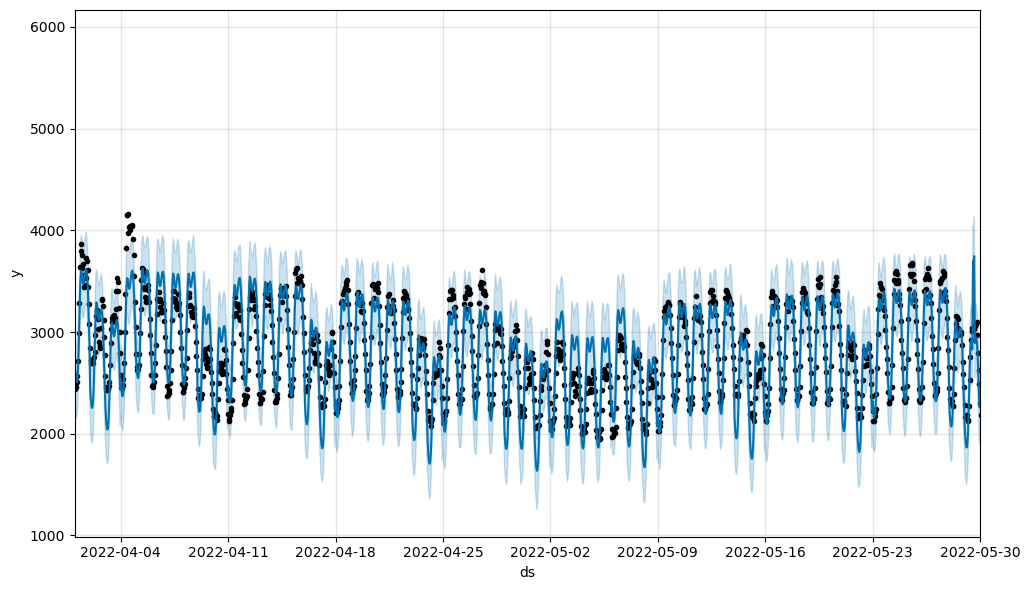

In [27]:
model_norm.plot(pred_norm)
plt.xlim(dt(2022, 4, 1), dt(2022, 5, 30))
plt.show()

In [28]:
df_2022 = pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-2022.csv', encoding='shift-jis', skiprows=1)
df_2022

,DATE,TIME,実績(万kW)
0,2022/1/1,0:00,3266
1,2022/1/1,1:00,3062
2,2022/1/1,2:00,2929
3,2022/1/1,3:00,2828
4,2022/1/1,4:00,2786
...,...,...,...
8755,2022/12/31,19:00,3354
8756,2022/12/31,20:00,3293
8757,2022/12/31,21:00,3206
8758,2022/12/31,22:00,3092


In [29]:
pred_2022 = pred_norm[(pred_norm['ds'] >= dt(2022, 1, 1)) & (pred_norm['ds'] < dt(2023, 1, 1))].reset_index(drop=True)
pred_2022

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,0,0_lower,0_upper,1,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01 00:00:00,2940.400680,2624.305719,3276.564372,2940.400680,2940.400680,0.0,0.0,0.0,167.324438,...,55.496355,55.496355,55.496355,274.887641,274.887641,274.887641,0.0,0.0,0.0,2961.466625
1,2022-01-01 01:00:00,2940.517787,2507.375574,3198.795062,2940.517787,2940.517787,0.0,0.0,0.0,167.324438,...,52.363362,52.363362,52.363362,275.025933,275.025933,275.025933,0.0,0.0,0.0,2845.978537
2,2022-01-01 02:00:00,2940.634895,2437.851213,3125.922552,2940.634895,2940.634895,0.0,0.0,0.0,167.324438,...,48.620017,48.620017,48.620017,275.169086,275.169086,275.169086,0.0,0.0,0.0,2781.239697
3,2022-01-01 03:00:00,2940.752002,2413.368144,3099.166614,2940.752002,2940.752002,0.0,0.0,0.0,167.324438,...,44.256327,44.256327,44.256327,275.317108,275.317108,275.317108,0.0,0.0,0.0,2756.226784
4,2022-01-01 04:00:00,2940.869110,2441.277427,3114.858057,2940.869110,2940.869110,0.0,0.0,0.0,167.324438,...,39.268365,39.268365,39.268365,275.470007,275.470007,275.470007,0.0,0.0,0.0,2777.474079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,2734.186748,3130.321002,3828.918288,2734.186748,2734.186748,0.0,0.0,0.0,167.324438,...,-93.795460,-93.795460,-93.795460,273.684813,273.684813,273.684813,0.0,0.0,0.0,3456.955873
8756,2022-12-31 20:00:00,2734.153766,3027.371519,3699.824985,2734.153766,2734.153766,0.0,0.0,0.0,167.324438,...,-104.281393,-104.281393,-104.281393,273.770208,273.770208,273.770208,0.0,0.0,0.0,3344.653769
8757,2022-12-31 21:00:00,2734.120784,2836.410548,3497.677830,2734.120784,2734.120784,0.0,0.0,0.0,167.324438,...,-114.579201,-114.579201,-114.579201,273.860365,273.860365,273.860365,0.0,0.0,0.0,3169.762334
8758,2022-12-31 22:00:00,2734.087802,2606.217690,3297.212342,2734.087802,2734.087802,0.0,0.0,0.0,167.324438,...,-124.611139,-124.611139,-124.611139,273.955294,273.955294,273.955294,0.0,0.0,0.0,2952.813910


In [30]:
df_2022 = df_2022.rename(columns={'実績(万kW)':'y'})

results = pd.DataFrame()

# 実測値
results['t'] = df_2022['y']

# 予測値
results['y'] = pred_2022['yhat']
results['diff'] = results['t'] - results['y']
results

,t,y,diff
0,3266,2961.466625,304.533375
1,3062,2845.978537,216.021463
2,2929,2781.239697,147.760303
3,2828,2756.226784,71.773216
4,2786,2777.474079,8.525921
...,...,...,...
8755,3354,3456.955873,-102.955873
8756,3293,3344.653769,-51.653769
8757,3206,3169.762334,36.237666
8758,3092,2952.813910,139.186090


In [31]:
np.mean(abs((results['y'] - results['t']) / results['t'])*100)

6.396692667028922

In [222]:
# 通常モデルの保存
joblib.dump(model_norm, 'model_norm_elec.pkl')

['model_norm_elec.pkl']

# 6℃以下モデル作成

In [124]:
df_c = df_p

df_pr = pd.DataFrame({
    'ds':df_p['ds'],
    'temp':df_p['気温(℃)']
})

def categorize_temp(temp):
    if temp <= -2.0:
        return 1
    elif -1.9 <= temp <= 0.9:
        return 0.8
    elif 1.0 <= temp <= 3.0:
        return 0.6
    elif 3.1 <=temp <= 5.0:
        return 0.4
    elif 5.1 <= temp <= 6.0:
        return 0.2
    else:
        return 0
df_pr['temp'] = df_pr['temp'].apply(categorize_temp)
df_c['temp'] = df_pr['temp']
df_c

,ds,DATE,TIME,y,天気,気温(℃),日射量(MJ/㎡),休・祝日,temp
0,2019-04-01 01:00:00,2019-04-01,01:00,2493,0,8.2,0.0,0,0.0
1,2019-04-01 02:00:00,2019-04-01,02:00,2480,0,7.8,0.0,0,0.0
2,2019-04-01 03:00:00,2019-04-01,03:00,2493,1,7.3,0.0,0,0.0
3,2019-04-01 04:00:00,2019-04-01,04:00,2547,0,7.1,0.0,0,0.0
4,2019-04-01 05:00:00,2019-04-01,05:00,2712,0,6.7,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
35059,2023-03-31 20:00:00,2023-03-31,20:00,2898,0,15.1,0.0,0,0.0
35060,2023-03-31 21:00:00,2023-03-31,21:00,2759,1,14.3,0.0,0,0.0
35061,2023-03-31 22:00:00,2023-03-31,22:00,2639,0,13.6,0.0,0,0.0
35062,2023-03-31 23:00:00,2023-03-31,23:00,2510,0,13.1,0.0,0,0.0


In [125]:
model_cold = Prophet(
    holidays=holidays)
model_cold.add_regressor('temp').fit(df_c)

22:03:08 - cmdstanpy - INFO - Chain [1] start processing
22:03:21 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
future = pd.DataFrame({
    'ds':df_n['ds'],
    'temp':df_n['temp']
})

future
pred_cold = model_cold.predict(future)

In [127]:
pred_cold.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,0,0_lower,0_upper,1,1_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,...,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.000000,35058.0,35058.0,35058.0,35058.000000
mean,2876.283186,2837.926966,3586.968298,2876.283186,2876.283186,281.642912,281.642912,281.642912,54.357411,54.357411,...,0.142916,0.142916,0.142916,0.000139,0.000139,0.000139,0.0,0.0,0.0,3212.352232
std,82.693293,602.123118,602.194260,82.693293,82.693293,196.743515,196.743515,196.743515,77.816116,77.816116,...,89.530525,89.530525,89.530525,318.454580,318.454580,318.454580,0.0,0.0,0.0,601.971911
min,2571.983313,1079.038725,1832.649280,2571.983313,2571.983313,0.000000,0.000000,0.000000,0.000000,0.000000,...,-207.736283,-207.736283,-207.736283,-594.299971,-594.299971,-594.299971,0.0,0.0,0.0,1459.270517
25%,2830.369058,2416.535368,3165.759734,2830.369058,2830.369058,0.000000,0.000000,0.000000,0.000000,0.000000,...,-32.891626,-32.891626,-32.891626,-287.388568,-287.388568,-287.388568,0.0,0.0,0.0,2792.568531
50%,2888.487847,2898.817840,3647.536739,2888.487847,2888.487847,419.075472,419.075472,419.075472,0.000000,0.000000,...,44.853755,44.853755,44.853755,33.680698,33.680698,33.680698,0.0,0.0,0.0,3274.201812
75%,2940.390152,3273.928909,4024.409029,2940.390152,2940.390152,419.075472,419.075472,419.075472,165.752988,165.752988,...,55.027620,55.027620,55.027620,251.725364,251.725364,251.725364,0.0,0.0,0.0,3649.996232
max,3064.197040,4502.616904,5209.105177,3064.197040,3064.197040,419.075472,419.075472,419.075472,165.752988,165.752988,...,88.807117,88.807117,88.807117,588.404479,588.404479,588.404479,0.0,0.0,0.0,4845.490238


In [128]:
pred_cold.loc[(pred_cold['yhat'].idxmax())]

ds                                 2023-01-25 10:00:00
trend                                      2773.814108
yhat_lower                                 4502.616904
yhat_upper                                 5209.105177
trend_lower                                2773.814108
trend_upper                                2773.814108
0                                           419.075472
0_lower                                     419.075472
0_upper                                     419.075472
1                                                  0.0
1_lower                                            0.0
1_upper                                            0.0
additive_terms                              2071.67613
additive_terms_lower                        2071.67613
additive_terms_upper                        2071.67613
daily                                       467.072042
daily_lower                                 467.072042
daily_upper                                 467.072042
extra_regr

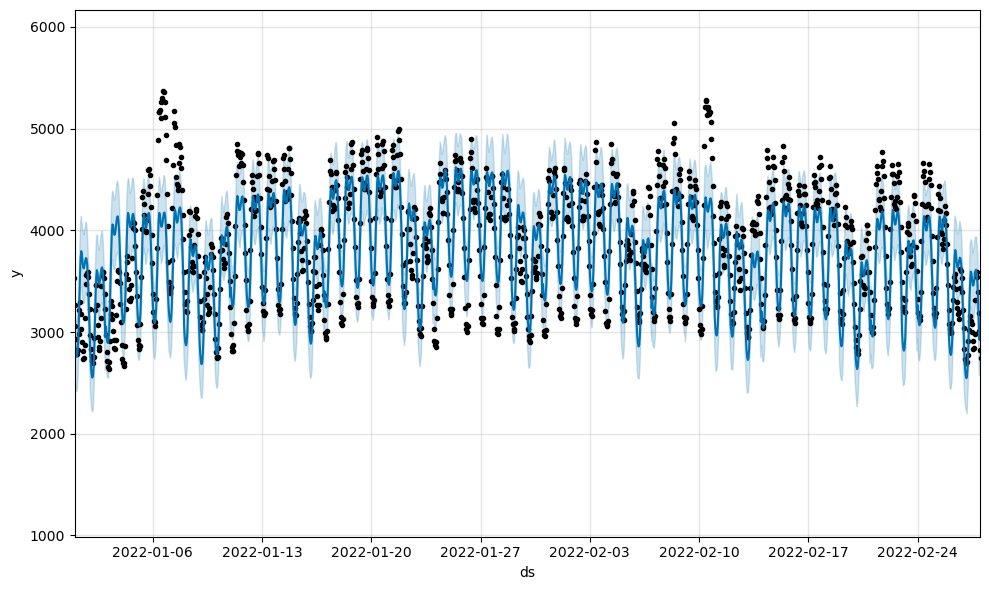

In [129]:
model_norm.plot(pred_norm)
plt.xlim(dt(2022, 1, 1), dt(2022, 2, 28))
plt.show()

In [130]:
f_2022 = pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-2022.csv', encoding='shift-jis', skiprows=1)
datetimes = []
for i, val in df_2022.iterrows():
    date = val['DATE']
    time = val['TIME']
    str_datetime = f'{date} {time}'
    datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
    datetimes.append(datetime)
df_2022['ds'] = pd.Series(datetimes[:len(df_2022)])
df_2022['ds'] = datetimes
df_2022['ds'] = pd.to_datetime(df_2022['ds'], format='%Y-%m-%d %H:%M')

df_2022 = df_2022[(df_2022['ds'] >= dt(2022, 1, 1)) & (df_2022['ds'] < dt(2022, 2, 28))].reset_index(drop=True)
df_2022

,DATE,TIME,y,ds
0,2022/1/1,0:00,3266,2022-01-01 00:00:00
1,2022/1/1,1:00,3062,2022-01-01 01:00:00
2,2022/1/1,2:00,2929,2022-01-01 02:00:00
3,2022/1/1,3:00,2828,2022-01-01 03:00:00
4,2022/1/1,4:00,2786,2022-01-01 04:00:00
...,...,...,...,...
1387,2022/2/27,19:00,3593,2022-02-27 19:00:00
1388,2022/2/27,20:00,3536,2022-02-27 20:00:00
1389,2022/2/27,21:00,3389,2022-02-27 21:00:00
1390,2022/2/27,22:00,3191,2022-02-27 22:00:00


In [131]:
pred_2022 = pred_cold[(pred_cold['ds'] >= dt(2022, 1, 1)) & (pred_cold['ds'] < dt(2022, 2, 28))].reset_index(drop=True)
pred_2022

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,0,0_lower,0_upper,1,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01 00:00:00,2954.888001,2973.892653,3711.722094,2954.888001,2954.888001,0.0,0.0,0.0,165.752988,...,60.391563,60.391563,60.391563,56.834602,56.834602,56.834602,0.0,0.0,0.0,3355.301086
1,2022-01-01 01:00:00,2954.927302,2840.986752,3623.293925,2954.927302,2954.927302,0.0,0.0,0.0,165.752988,...,57.108085,57.108085,57.108085,56.801176,56.801176,56.801176,0.0,0.0,0.0,3232.666027
2,2022-01-01 02:00:00,2954.966604,2772.594164,3539.876763,2954.966604,2954.966604,0.0,0.0,0.0,165.752988,...,53.142916,53.142916,53.142916,56.773469,56.773469,56.773469,0.0,0.0,0.0,3163.744949
3,2022-01-01 03:00:00,2955.005905,2770.633876,3543.866525,2955.005905,2955.005905,0.0,0.0,0.0,165.752988,...,48.487397,48.487397,48.487397,56.751489,56.751489,56.751489,0.0,0.0,0.0,3133.570610
4,2022-01-01 04:00:00,2955.045207,2757.354779,3523.483145,2955.045207,2955.045207,0.0,0.0,0.0,165.752988,...,43.139782,43.139782,43.139782,56.735246,56.735246,56.735246,0.0,0.0,0.0,3145.512644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,2022-02-27 19:00:00,2963.801988,3063.721974,3803.655114,2963.801988,2963.801988,0.0,0.0,0.0,165.752988,...,-174.088060,-174.088060,-174.088060,158.801296,158.801296,158.801296,0.0,0.0,0.0,3443.363331
1388,2022-02-27 20:00:00,2963.787264,2963.301267,3711.239003,2963.787264,2963.787264,0.0,0.0,0.0,165.752988,...,-165.848422,-165.848422,-165.848422,158.452420,158.452420,158.452420,0.0,0.0,0.0,3333.678627
1389,2022-02-27 21:00:00,2963.772541,2797.911195,3555.387790,2963.772541,2963.772541,0.0,0.0,0.0,165.752988,...,-156.887324,-156.887324,-156.887324,158.100369,158.100369,158.100369,0.0,0.0,0.0,3169.983118
1390,2022-02-27 22:00:00,2963.757817,2567.186308,3330.009640,2963.757817,2963.757817,0.0,0.0,0.0,165.752988,...,-147.274253,-147.274253,-147.274253,157.745132,157.745132,157.745132,0.0,0.0,0.0,2965.928310


In [132]:
df_2022 = df_2022.rename(columns={'実績(万kW)':'y'})

results = pd.DataFrame()

# 実測値
results['t'] = df_2022['y']

# 予測値
results['y'] = pred_2022['yhat']
results['diff'] = results['t'] - results['y']
results

,t,y,diff
0,3266,3355.301086,-89.301086
1,3062,3232.666027,-170.666027
2,2929,3163.744949,-234.744949
3,2828,3133.570610,-305.570610
4,2786,3145.512644,-359.512644
...,...,...,...
1387,3593,3443.363331,149.636669
1388,3536,3333.678627,202.321373
1389,3389,3169.983118,219.016882
1390,3191,2965.928310,225.071690


In [133]:
np.mean(abs((results['y'] - results['t']) / results['t'])*100)

6.351632435962607

In [134]:
# ６℃以下モデルの保存
joblib.dump(model_cold, 'model_cold_elec.pkl')

['model_cold_elec.pkl']

In [76]:
# 需要量：４０００以上かつ気温１５℃以下グラフ

df4000_15 = df_p[(df_p['y'] >= 4000) & (df_p['気温(℃)'] <=15.0)]
df4000_15


,ds,DATE,TIME,y,天気,気温(℃),日射量(MJ/㎡),休・祝日,temp
224,2019-04-10 09:00:00,2019-04-10,09:00,4147,10,6.1,0.15,0,0.0
225,2019-04-10 10:00:00,2019-04-10,10:00,4210,0,6.0,0.26,0,0.2
226,2019-04-10 11:00:00,2019-04-10,11:00,4225,0,5.7,0.22,0,0.2
227,2019-04-10 12:00:00,2019-04-10,12:00,4055,10,5.3,0.29,0,0.2
228,2019-04-10 13:00:00,2019-04-10,13:00,4155,0,5.0,0.31,0,0.4
...,...,...,...,...,...,...,...,...,...
34160,2023-02-22 09:00:00,2023-02-22,09:00,4222,1,4.2,1.45,0,0.4
34161,2023-02-22 10:00:00,2023-02-22,10:00,4146,0,5.8,2.07,0,0.2
34162,2023-02-22 11:00:00,2023-02-22,11:00,4044,0,7.5,2.51,0,0.0
34169,2023-02-22 18:00:00,2023-02-22,18:00,4065,1,6.6,0.04,0,0.0


In [77]:
df4000_15.describe()

,y,天気,気温(℃),日射量(MJ/㎡),休・祝日,temp
count,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000,2414.000000
mean,4302.888981,1.073322,6.383761,0.544068,0.076636,0.178956
std,243.907257,2.311974,2.751982,0.702716,0.266069,0.234712
min,4000.000000,0.000000,-3.200000,0.000000,0.000000,0.000000
25%,4114.000000,0.000000,4.500000,0.000000,0.000000,0.000000
50%,4247.000000,0.000000,6.500000,0.210000,0.000000,0.000000
75%,4438.000000,1.000000,8.400000,0.910000,0.000000,0.400000
max,5374.000000,12.000000,14.600000,2.800000,1.000000,1.000000


In [80]:
df4000_15.loc[df4000_15['y'].idxmax()]

ds           2022-01-06 16:00:00
DATE                  2022-01-06
TIME                       16:00
y                           5374
天気                             0
気温(℃)                       -0.2
日射量(MJ/㎡)                   0.04
休・祝日                           0
temp                         0.8
Name: 24279, dtype: object

In [ ]:
# 周期性の確認
# model.plot_components(pred)
# plt.show()

In [106]:
# 気温と需要量対比グラフ

# side = df_p['気温(℃)']
# down = df_p['y']

# plt.figure(figsize=(30, 20 ))

# plt.scatter(side, down, marker=4)
# plt.minorticks_on()
# plt.grid(which='both')
# plt.show()

In [223]:
# 需要量：４０００以上かつ気温１５℃以下グラフ

df4000_15 = df_p[(df_p['y'] >= 4000) & (df_p['気温(℃)'] <=15.0)]
df4000_15

df4000_15.describe()

,y,天気,気温(℃),日射量(MJ/㎡),休・祝日,temp
count,2415.000000,2415.000000,2415.000000,2414.000000,2415.000000,2415.0
mean,4302.873292,1.074534,6.384389,0.544068,0.076605,0.0
std,243.857952,2.312262,2.751585,0.702716,0.266018,0.0
min,4000.000000,0.000000,-3.200000,0.000000,0.000000,0.0
25%,4114.000000,0.000000,4.500000,0.000000,0.000000,0.0
50%,4247.000000,0.000000,6.500000,0.210000,0.000000,0.0
75%,4438.000000,1.000000,8.400000,0.910000,0.000000,0.0
max,5374.000000,12.000000,14.600000,2.800000,1.000000,0.0


In [14]:
# 需要量：４０００以上かつ気温２５℃以下グラフ

df4000_25 = df_p[(df_p['y']>=4000) & (df_p['気温(℃)']>=25.0)]
df4000_25

,ds,DATE,TIME,y,天気,気温(℃),日射量(MJ/㎡),休・祝日
1354,2019-05-27 11:00:00,2019-05-27,11:00,4097,0,30.3,3.20,0
1355,2019-05-27 12:00:00,2019-05-27,12:00,4013,3,31.0,3.34,0
1356,2019-05-27 13:00:00,2019-05-27,13:00,4203,0,31.2,3.08,0
1357,2019-05-27 14:00:00,2019-05-27,14:00,4229,0,31.1,3.10,0
1358,2019-05-27 15:00:00,2019-05-27,15:00,4184,2,31.3,2.50,0
...,...,...,...,...,...,...,...,...
30612,2022-09-27 13:00:00,2022-09-27,13:00,4023,0,27.3,2.13,0
30613,2022-09-27 14:00:00,2022-09-27,14:00,4039,0,27.3,0.84,0
30780,2022-10-04 13:00:00,2022-10-04,13:00,4145,0,28.7,2.57,0
30781,2022-10-04 14:00:00,2022-10-04,14:00,4174,0,28.5,2.07,0


In [17]:
df4000_25.describe()

,y,天気,気温(℃),日射量(MJ/㎡),休・祝日
count,2302.000000,2302.000000,2302.000000,2302.000000,2302.000000
mean,4538.268462,1.022589,30.284361,1.568766,0.156386
std,429.793119,1.923440,2.356787,1.038063,0.363300
min,4000.000000,0.000000,25.000000,0.000000,0.000000
25%,4177.250000,0.000000,28.500000,0.670000,0.000000
50%,4428.000000,0.000000,30.200000,1.585000,0.000000
75%,4839.750000,2.000000,32.100000,2.440000,0.000000
max,5930.000000,15.000000,36.700000,3.510000,1.000000


In [13]:
# 需要量：４０００以上かつ気温２５℃以下グラフ

side = df4500_30['気温(℃)']
down = df4500_30['y']

plt.figure(figsize=(30, 20 ))

plt.scatter(side, down)
plt.minorticks_on()
plt.grid(which='both')
plt.show()

NameError: name 'df4500_30' is not defined

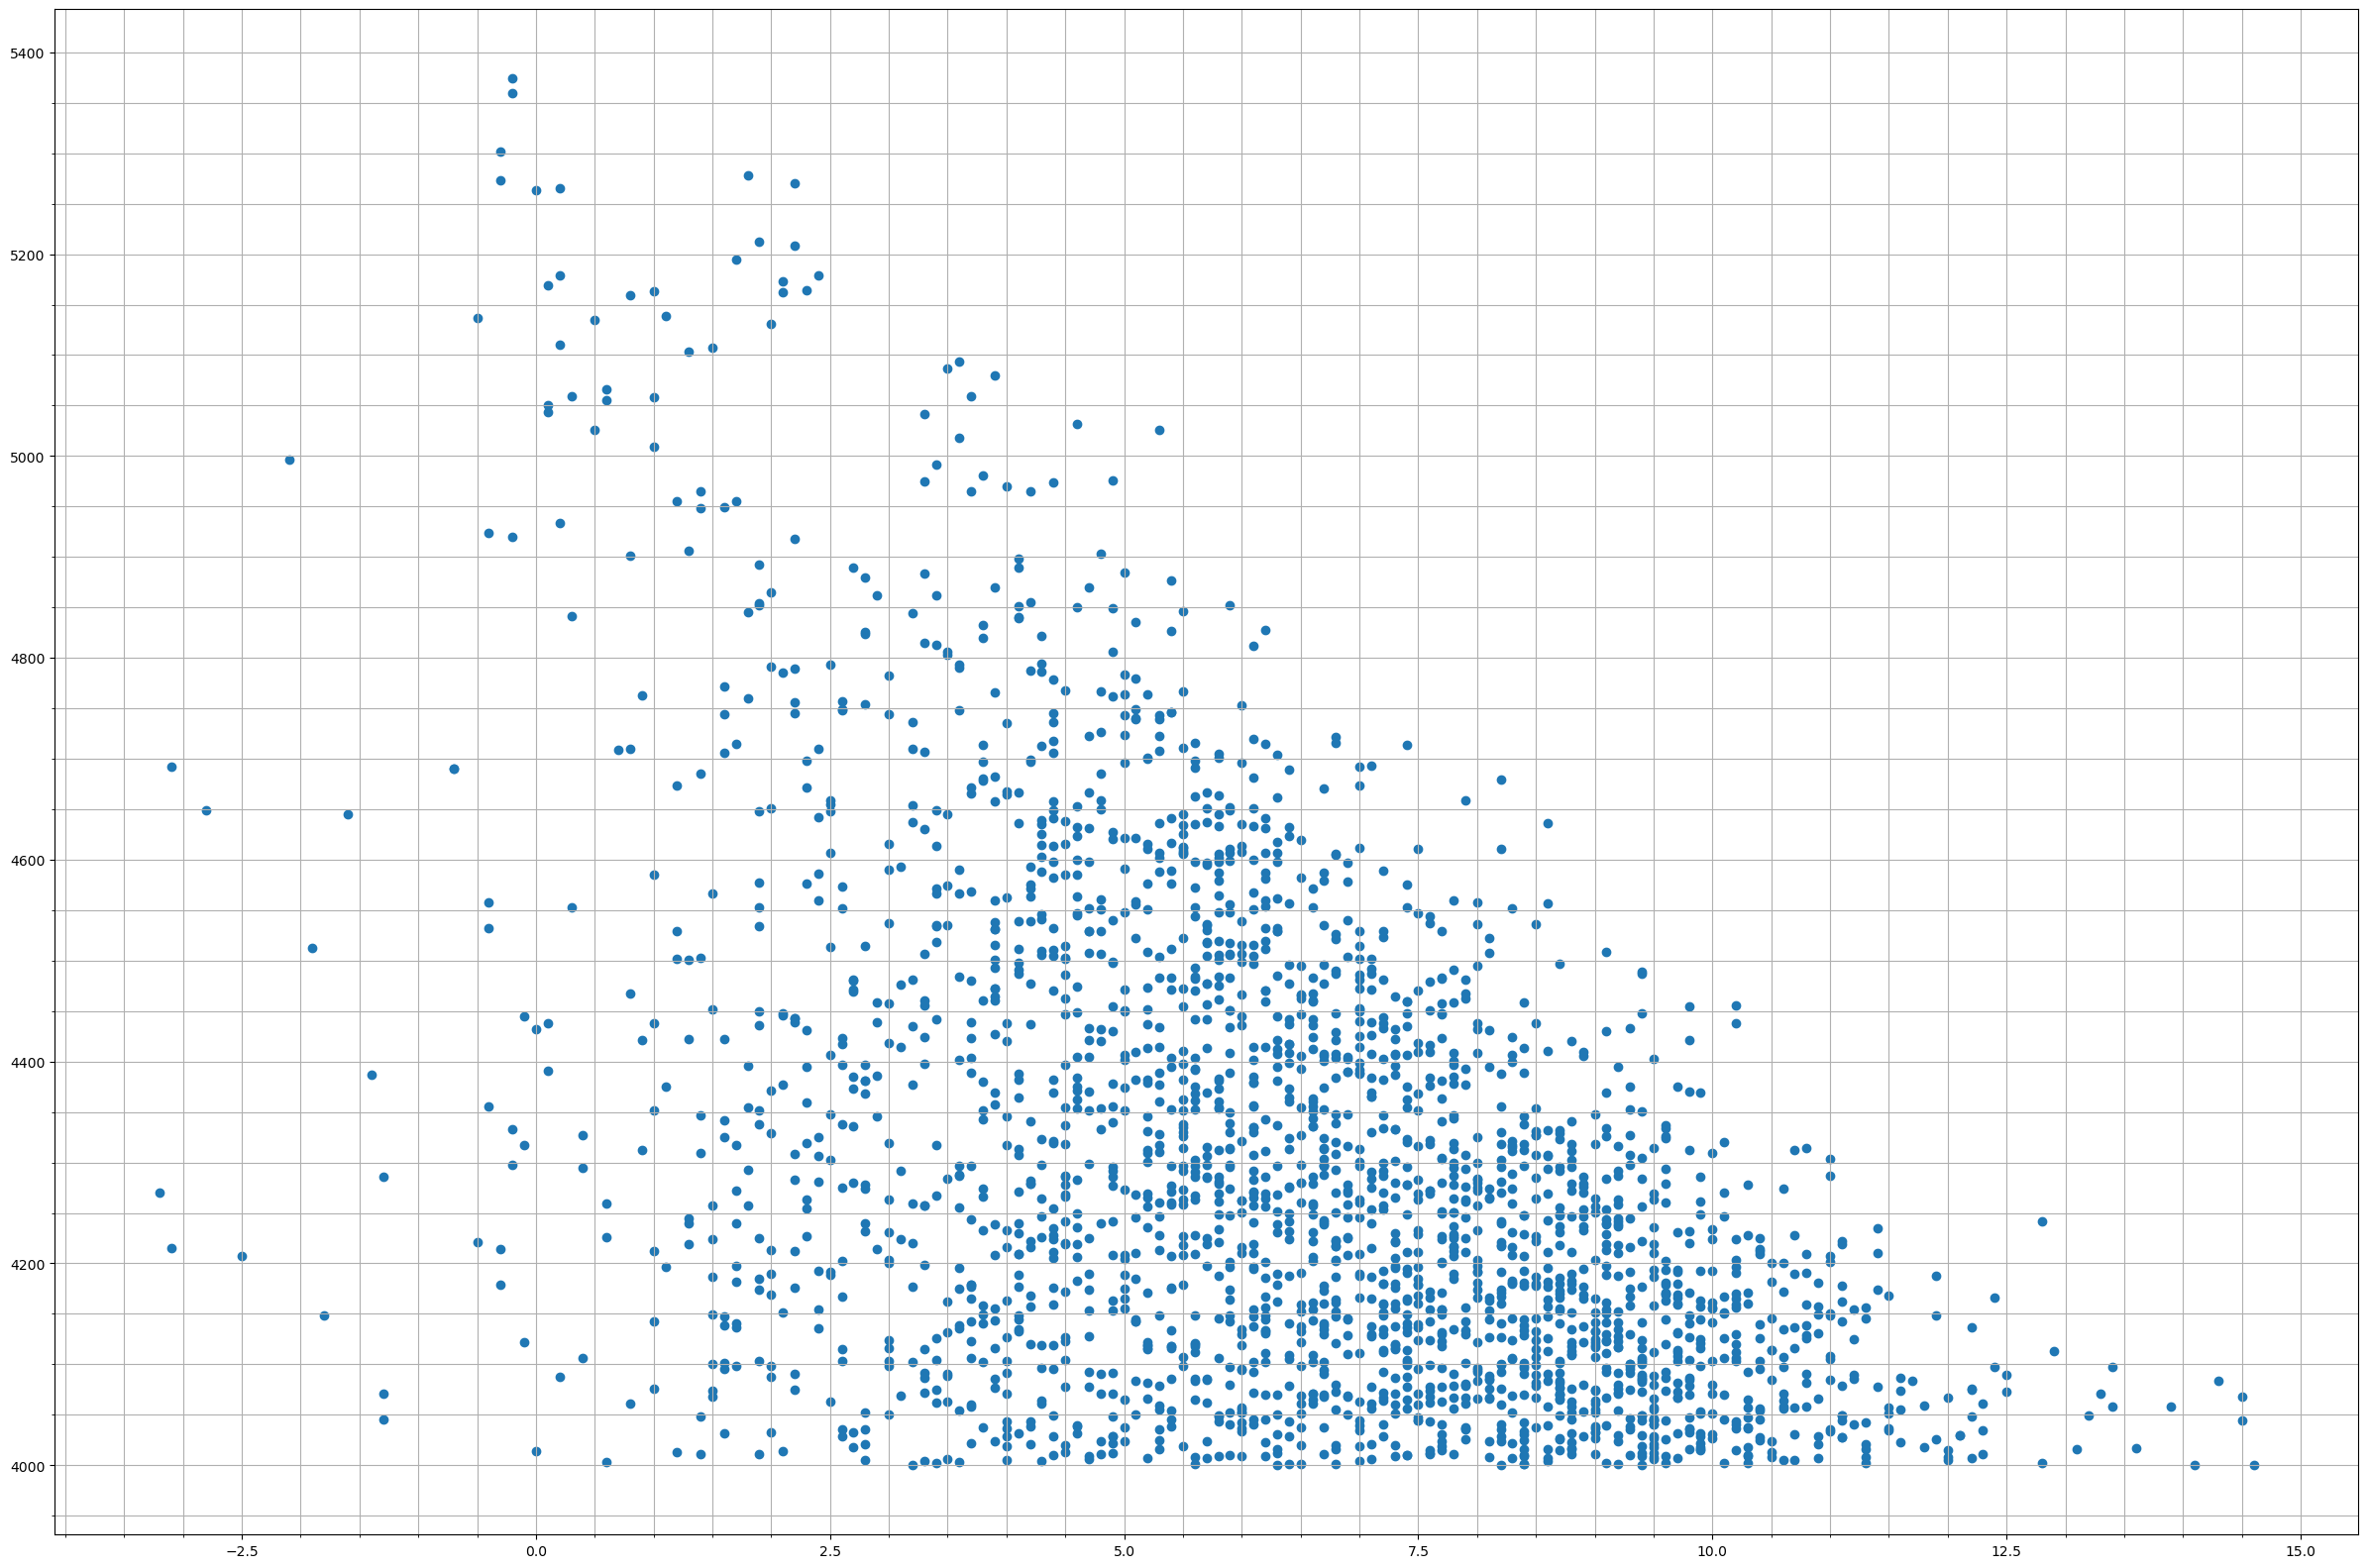

In [91]:
# 需要量：４０００以上かつ気温１５℃以下グラフ

side = df4000_15['気温(℃)']
down = df4000_15['y']

plt.figure(figsize=(30, 20 ))

plt.scatter(side, down)
plt.minorticks_on()
plt.grid(which='both')
plt.show()